In [16]:
import cv2 
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

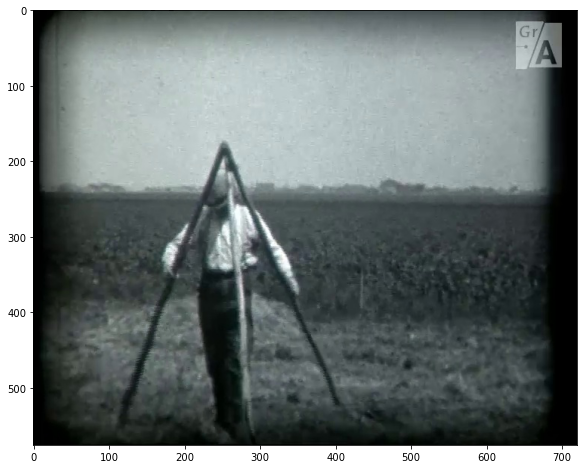

In [17]:
# Loading example image 

#img = plt.imread("frames/AV2171/keyframe_1867.0.jpg")
img = plt.imread("frames/AV0843/keyframe_9145.0.jpg")
#img = plt.imread("frames/contemporary/IMG_2864.jpeg")
#img = plt.imread("frames/AV0539/keyframe_2966.0.jpg")
#img = cv2.imread("/Users/blazejmanczak/Desktop/sudoku.jpg")
plt.figure(figsize = (10,8))
plt.imshow(img, cmap = "gray")

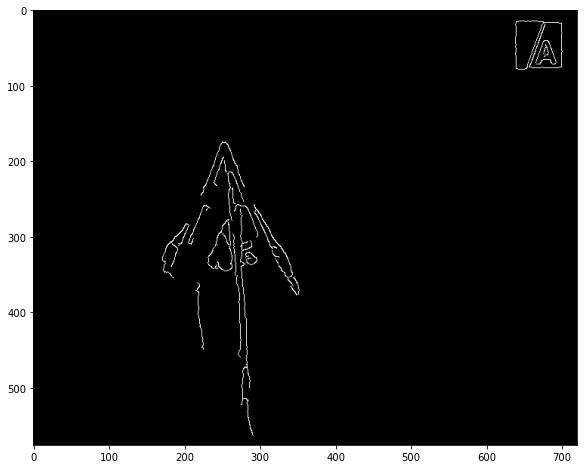

In [18]:
#gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
blurred_image = cv2.GaussianBlur(img, (7, 7), 0) # filter out week lines
edges_image = cv2.Canny(blurred_image, 50, 200, apertureSize = 3) # 120 is another visually optimal value 
plt.figure(figsize = (10,8))
plt.imshow(edges_image, cmap = "gray")

### Non-probabailist Hough transform 
Some code snippets from: https://medium.com/@tomasz.kacmajor/hough-lines-transform-explained-645feda072ab


In [19]:
def draw_lines(img, houghLines, color=[0, 255, 0], thickness=2):
    for line in houghLines:
        for rho,theta in line:
            a = np.cos(theta)
            b = np.sin(theta)
            x0 = a*rho
            y0 = b*rho
            x1 = int(x0 + 1000*(-b))
            y1 = int(y0 + 1000*(a))
            x2 = int(x0 - 1000*(-b))
            y2 = int(y0 - 1000*(a))
 
            cv2.line(img,(x1,y1),(x2,y2),color,thickness)   
                
 
def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    return cv2.addWeighted(initial_img, α, img, β, λ)

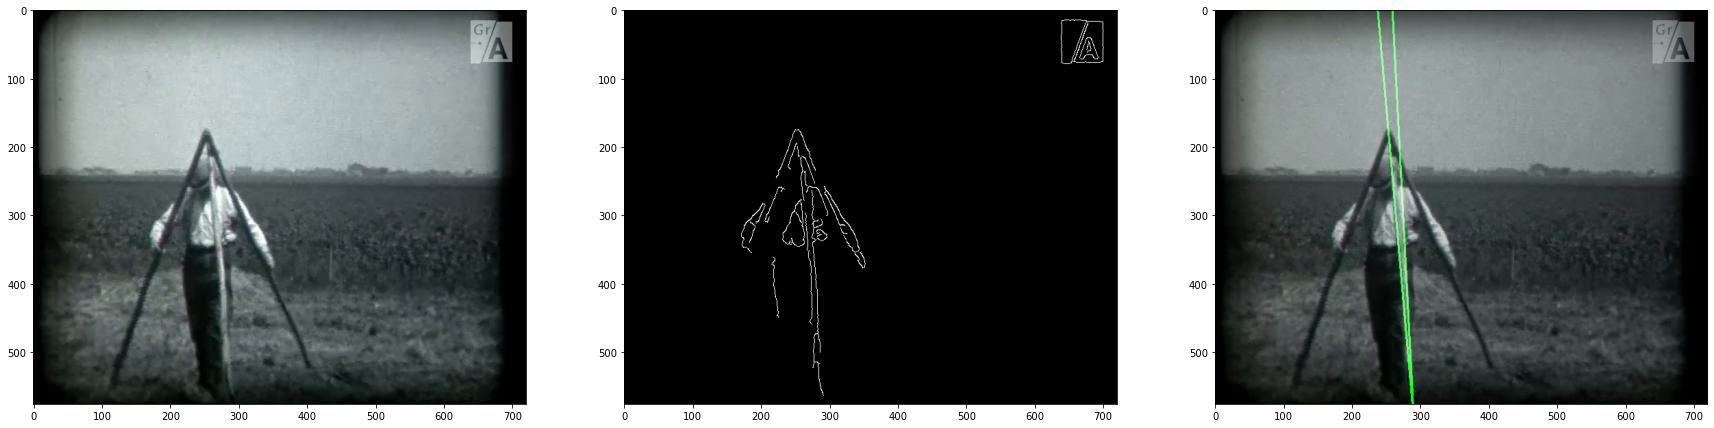

In [20]:
rho_resolution = 1
theta_resolution = np.pi/180
threshold = 100 #Only lines that are greater than threshold will be returned.
 
hough_lines = cv2.HoughLines(edges_image, rho_resolution , theta_resolution , threshold)
 
hough_lines_image = np.zeros_like(img)
draw_lines(hough_lines_image, hough_lines)
original_image_with_hough_lines = weighted_img(hough_lines_image,img)
 
plt.figure(figsize = (30,20))
plt.subplot(131)
plt.imshow(img)
plt.subplot(132)
plt.imshow(edges_image, cmap='gray')
plt.subplot(133)
plt.imshow(original_image_with_hough_lines, cmap='gray') 

### Probabilistic Hough transform 
This tutorial has been useful: https://docs.opencv.org/3.4/d9/db0/tutorial_hough_lines.html, especially for interpretting the function parameters

1 0.017453292519943295 100 150 30
6


(<AxesSubplot:>, <matplotlib.image.AxesImage at 0x7fd34f1722e0>)

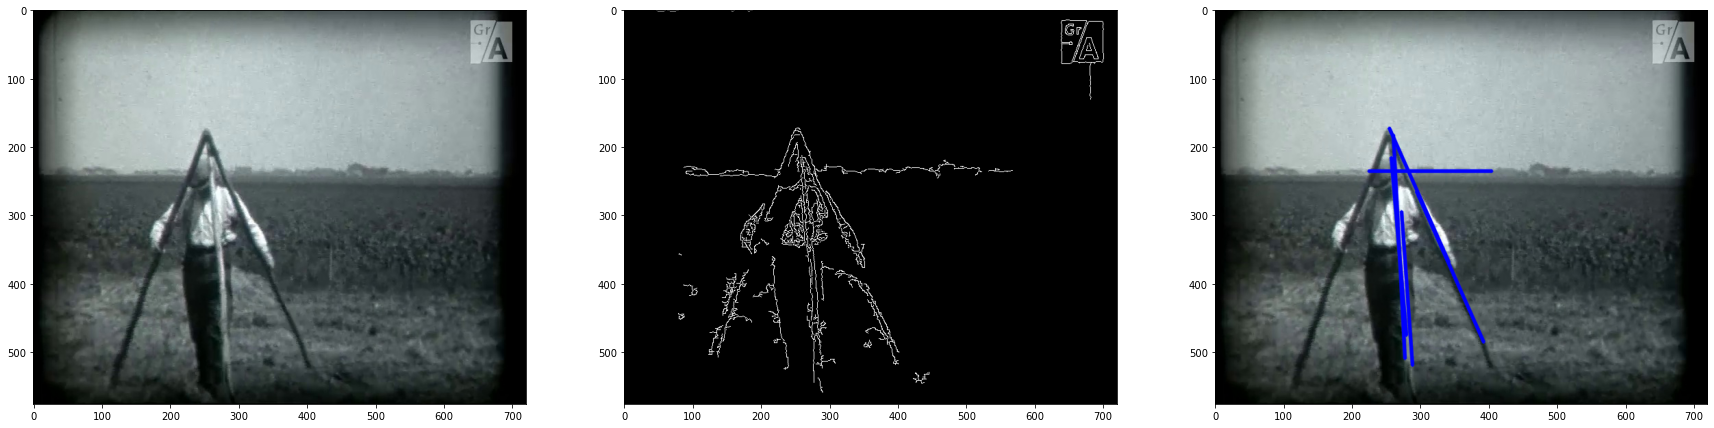

In [21]:
threshold = 100 # The minimum number of intersections in hough space to "detect" a line. higher -> less lines
minLineLength = 150 # The minimum number of points that can form a line. Lines with less than this number of points are disregarded. higher -> less lines
maxLineGap = 30 # The maximum gap between two points to be considered in the same line. higher -> more lines


edges_image = cv2.Canny(img, 50, 200,None, apertureSize = 3)  # without Blur
hough_lines_p = cv2.HoughLinesP(edges_image,1, np.pi / 180, threshold, None, minLineLength, maxLineGap)
print(1, np.pi/180, threshold, minLineLength, maxLineGap)
print(len(hough_lines_p))

original_image_with_hough_lines = img.copy()

for i in range(0, len(hough_lines_p)):
        l = hough_lines_p[i][0]
        cv2.line(original_image_with_hough_lines, (l[0], l[1]), (l[2], l[3]), (0,0,255), 3, cv2.LINE_AA)

#original_image_with_hough_lines = weighted_img(hough_lines_p_image,img)
    
plt.figure(figsize = (30,20))
plt.subplot(131), plt.imshow(img)
plt.subplot(132), plt.imshow(edges_image, cmap='gray')
plt.subplot(133), plt.imshow(original_image_with_hough_lines, cmap='gray') 

## Wrapping the transformations into a function

In [22]:
# Set the parameters

rho_resolution = 1
theta_resolution = np.pi/180
threshold = 100 # The minimum number of intersections in hough space to "detect" a line. higher -> less lines

# Additional parameters for probabilistic
minLineLength = 150 # The minimum number of points that can form a line. Lines with less than this number of points are disregarded. higher -> less lines
maxLineGap = 30 # The maximum gap between two points to be considered in the same line. higher -> more lines


def apply_hough(img, minLineLength = minLineLength, maxLineGap = maxLineGap, probabilistic = True):
    """Applies the Hough transform""" 
    
    if probabilistic:
        edges_image = cv2.Canny(img, 50, 200,None, apertureSize = 3)  # without Blur
        hough_lines = cv2.HoughLinesP(edges_image,rho_resolution, theta_resolution, threshold, None, minLineLength, maxLineGap)
        
    else:
        blurred_image = cv2.GaussianBlur(img, (7, 7), 0) # filter out week lines
        edgs_image = cv2.Canny(blurred_image, 50, 150, apertureSize = 3) # 120 is another visually optimal value 
        hough_lines = cv2.HoughLines(edges_image, rho_resolution , theta_resolution , threshold)
     
    return hough_lines

def get_angle(hough_lines, radians = False):
    if radians:
        return np.arctan2(hough_lines[:, :,3] - hough_lines[:, :,1], hough_lines[:, :,2] - hough_lines[:, :,0])
    else: 
        return np.arctan2(hough_lines[:, :,3] - hough_lines[:, :,1], hough_lines[:, :,2] - hough_lines[:, :,0]) * 180/np.pi # better for numerical stability
    

def plot_lines(img, hough_lines, probabilistic = True):
    """Plots only probabilistic """

    original_image_with_hough_lines = img.copy()
    cmap = "gray" if img.shape[-1] == 3 else None 
        
    if probabilistic:
        for i in range(0, len(hough_lines)):
            l = hough_lines[i][0]
            cv2.line(original_image_with_hough_lines, (l[0], l[1]), (l[2], l[3]), (0,0,255), 3, cv2.LINE_AA)
            #break
    
    else:
        hough_lines_image = np.zeros_like(img)
        draw_lines(hough_lines_image, hough_lines)
        original_image_with_hough_lines = weighted_img(hough_lines_image,img)
    
    plt.figure(figsize = (15,10))
    plt.subplot(121), plt.imshow(img)
    plt.subplot(122), plt.imshow(original_image_with_hough_lines, cmap=cmap) 
    

"""
# Example usage
probabilistic = True

#img = plt.imread("frames/contemporary/IMG_2864.jpeg")
hough_lines = apply_hough(img, probabilistic = probabilistic)
plot_lines(img, hough_lines, probabilistic = probabilistic)
"""


'\n# Example usage\nprobabilistic = True\n\n#img = plt.imread("frames/contemporary/IMG_2864.jpeg")\nhough_lines = apply_hough(img, probabilistic = probabilistic)\nplot_lines(img, hough_lines, probabilistic = probabilistic)\n'

## Obtaining lines from the archive

- TO-DO: make a reliable model to choose the images (e.g. using correlation and naming paths # name of the file 
- TO-DO: merge overlapping lines together 
- What features do we want to use for the clustering? Length and angle? Or only angle

In [23]:
#img_directory = "frames/AV0539"
img_directory = ['AV4508', 'AV0539', 'AV5361', 'AV0843', 'AV2171']
img_paths = []
temp_list = []
for directory in img_directory:
    temp_list += list(os.listdir(os.path.join("frames",directory)))
    
    for path in temp_list:
        img_paths.append(os.path.join("frames", directory, path))
        
    temp_list = []
    

img_paths = list(sorted(img_paths))

img_paths = np.random.choice(img_paths, size = int(1*len(img_paths)), replace = False) # take a random sample of 10$ of one directory
img_paths = img_paths.astype(str)

#imgs = np.array([cv2.imread(os.path.join(img_directory, path)) for path in img_paths])
#flat_imgs = imgs.reshape(imgs.shape[0], imgs.shape[1]*imgs.shape[2]*imgs.shape[3]) # used to calculate correlation using np.corrcoef 

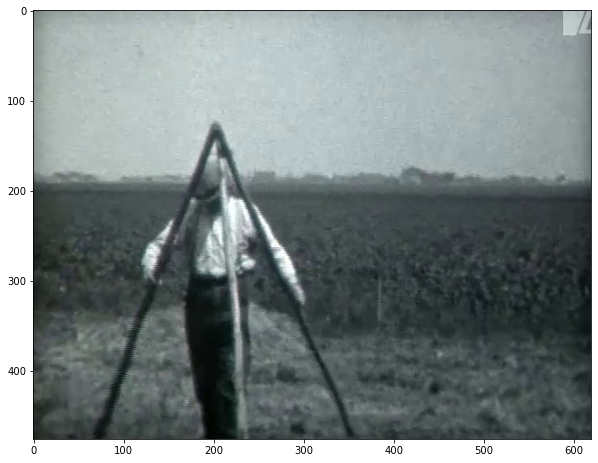

In [24]:
plt.figure(figsize = (10,8))
margin = 50
plt.imshow(img[margin:-margin, margin:-margin])

In [25]:
class matchingObjects:
    
    def __init__(self, path = None, margin = 50, img = None):
        
        if img is None: # read in the image from path
            
            self.path = path

            if margin > 0: # deals with black borders that result in many fake line detections
                self.img = plt.imread(self.path)[margin:-margin, margin:-margin]
            else:
                self.img = plt.imread(self.path)
        
        elif path is None: # np array image is provided
            self.path = None
            if margin > 0: # deals with black borders that result in many fake line detections
                self.img = img[margin:-margin, margin:-margin]
            else:
                self.img = img   
            
        self.shape = self.img.shape
    
    def hough_lines(self, probabilistic = True, radians = False):
        self.lines = apply_hough(self.img, probabilistic= probabilistic)

        if self.lines is not None: # if hough found something
            self.angle = get_angle(self.lines, radians = radians) # radians more stable
            
            x_diff = self.lines[:, :,2] - self.lines[:, :,0]# if 0 then slope will be -inf -> vertical line
            y_diff = self.lines[:, :,3] - self.lines[:, :,1] 
            self.slope = y_diff/x_diff
            self.length = np.sqrt(x_diff**2 + y_diff**2)
    
    def rank_and_pick_lines(self, delta_angle = 1, max_lines = None):
        #print("Intiail max:", np.max(self.length))
        initial_max = np.max(self.length)
        #print("initial", intial_max)
        if self.lines is not None:
            lst0 = self.lines
            order = np.arange(0, len(lst0)).reshape(-1,1)
            lst1 = self.angle
            lst2 = self.length
            merged = np.concatenate([lst1, lst2, order], axis = 1)
            new_order = np.lexsort((lst2, lst1), axis = 0) # sorts first by angle then by length
            merged_new = merged[new_order] 
            #print("merged_new:", merged_new)
            
            
            mask = ( np.diff(merged[new_order], axis = 0)[:,:,0] < delta_angle ) 
            series = False
            
            for i in range(len(mask)): # marks 
                if mask[i] == True:
                    series = True
                elif (mask[i] == False) and (series == True):
                    mask[i] = True # make up for the offset in the mask
                    series = False # break the series
                    
            
            grouping_mask = np.concatenate((mask, np.array([[False]])) )
            accum = []
            temp = []


            for i in range(len(grouping_mask)):  
                #print("current row", merged_new[i,:,:])
                if grouping_mask[i] == False:
                    if (len(temp)>0): 
                        #print("temp:", temp)

                        accum.append(np.array(temp)[np.argmax(np.array(temp), axis = 0)[0][1]])
                        #print("added to accum:", np.array(temp)[np.argmax(np.array(temp), axis = 0)[0][1]])
                        temp = []
                    accum.append(merged_new[i,:,:])


                else: #if grouping_mask[i] == True:

                    if len(temp) > 0:
                        if abs(merged_new[i,:,:][0][0] - temp[-1][0][0]) < delta_angle: 
                            temp.append(merged_new[i,:,:])
                        else: 
                            #print("else temp:", temp)
                            accum.append(np.array(temp)[np.argmax(np.array(temp), axis = 0)[0][1]])
                            #print("added to accum:", np.array(temp)[np.argmax(np.array(temp), axis = 0)[0][1]])
                            temp = []
                            temp.append(merged_new[i,:,:])
                    else:

                        temp.append(merged_new[i,:,:])
            #print("pre sort accum", accum)   
            
            accum = np.array(accum)
            accum = accum[np.argsort(accum[:,:,1], axis = 0)] # sort by length
            #print("Accum", accum)
            if max_lines is not None: # if the maximum number of lines to be returned is specifed, pick the longest lines
                accum = accum[-max_lines:]
            #print(accum)
            cleaned_order = list(accum[:,:,:,2].flatten().astype(int))
            #print("Cleaned orderd:", cleaned_order)
            #print("self lines before slicing", [self.lines, self.length])
            
            self.lines = self.lines[cleaned_order]
            self.angle = self.angle[cleaned_order]
            self.length = self.length[cleaned_order]
            #print("self lines AFTER slicing", [self.lines, self.length])
            self.slope = self.slope[cleaned_order]
            final_max = np.max(self.length)
            #print(final_max, intial_max)
            assert (abs(final_max - initial_max) < 0.01) # making sure
            #print(np.max(self.length))
        
        def plot_matches(self, matches, buffer = 5):
            self.matched_img = np.copy(self.img)
            pass
                
def get_non_zero_objects(obj_list):
    new_obj_list = []
    count_lines = 0
    for obj in obj_list:
        if obj.lines is not None:
            new_obj_list.append(obj)
            count_lines += len(obj.lines)
            
            
    print("{}% of input list contain lines".format(round(len(new_obj_list)/len(obj_list) * 100), 2))
    print("Given that the img contains a line, on average there are {} detected lines per image".format( round( count_lines/len(new_obj_list), 2 ) ))
    return new_obj_list
        

In [26]:
import time

start = time.time()

img_objects = np.array([matchingObjects(path) for path in img_paths])

# Apply hough transform to all objects in the array above
for obj in img_objects:
    obj.hough_lines()
    
non_zero_objects = get_non_zero_objects(img_objects)

print("Running hough lines for {} imgages took {} seconds.".format(len(img_paths), round(time.time() - start, 2)))

<ipython-input-25-6b4d87fe0ef6>:31: RuntimeWarning: divide by zero encountered in true_divide
  self.slope = y_diff/x_diff


51% of input list contain lines
Given that the img contains a line, on average there are 12.24 detected lines per image
Running hough lines for 3330 imgages took 59.62 seconds.


### Showacse of the line filtering method
Plots before and after applying the filtering of the lines

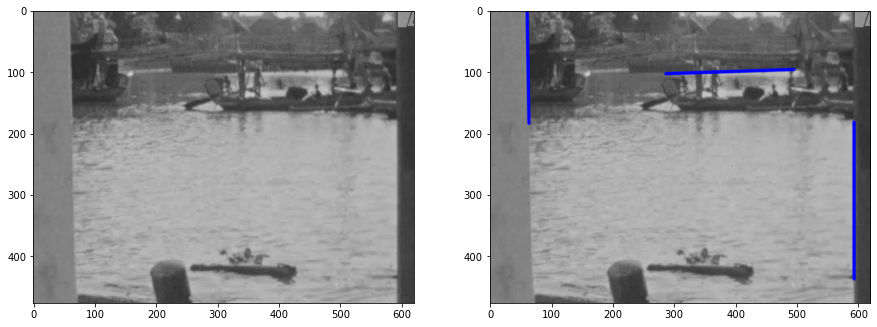

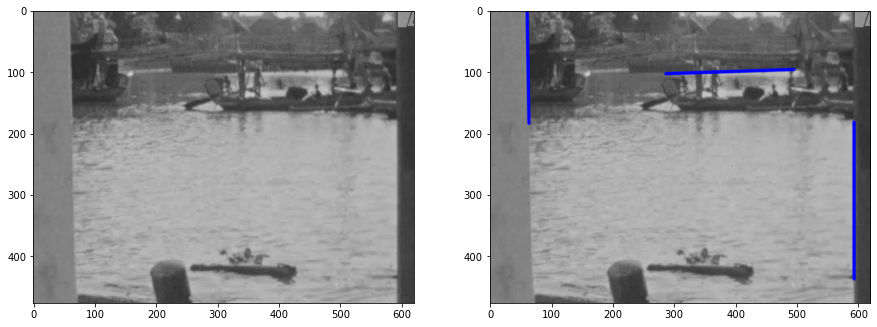

In [27]:
sample_number = 1 # 3
plot_lines(non_zero_objects[sample_number].img, non_zero_objects[sample_number].lines)
non_zero_objects[sample_number].rank_and_pick_lines(delta_angle=3, max_lines=3)
plot_lines(non_zero_objects[sample_number].img, non_zero_objects[sample_number].lines)

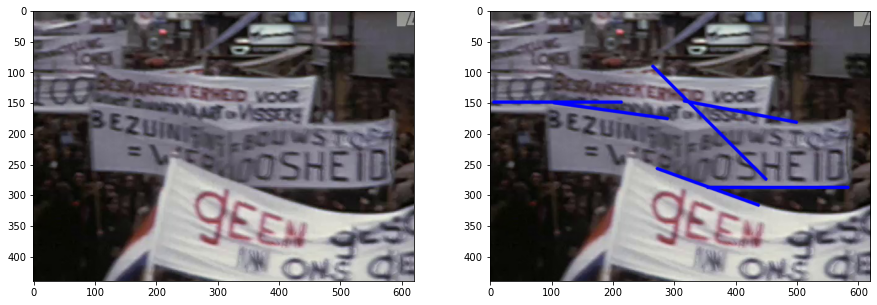

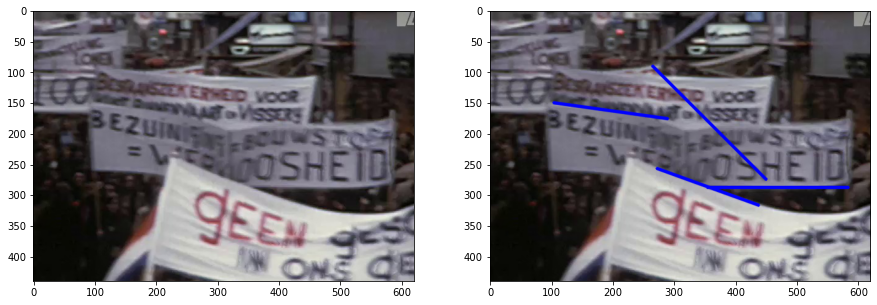

In [28]:
sample_number = 17 # 3
plot_lines(non_zero_objects[sample_number].img, non_zero_objects[sample_number].lines)
non_zero_objects[sample_number].rank_and_pick_lines(delta_angle=3, max_lines=None)
plot_lines(non_zero_objects[sample_number].img, non_zero_objects[sample_number].lines)

In [67]:
img = plt.imread("frames/contemporary/IMG_2864.jpeg")
#img = plt.imread("frames/AV0539/keyframe_2966.0.jpg")
#img = cv2.imread("/Users/blazejmanczak/Desktop/sudoku.jpg")
obj = matchingObjects(img = img, margin = 0)
obj.hough_lines()

<ipython-input-66-fca15e65b2b1>:31: RuntimeWarning: divide by zero encountered in true_divide
  self.slope = y_diff/x_diff


In [68]:
"""
lst0 = non_zero_objects[17].lines
order = np.arange(0, len(lst0)).reshape(-1,1)
lst1 = non_zero_objects[17].angle
lst2 = non_zero_objects[17].length

print(len(lst0), len(lst1), len(lst2))
merged = np.concatenate([lst1, lst2, order], axis = 1)

"""

lst0 = obj.lines
order = np.arange(0, len(lst0)).reshape(-1,1)
lst1 = obj.angle
lst2 = obj.length

print(len(lst0), len(lst1), len(lst2))
merged = np.concatenate([lst1, lst2, order], axis = 1)

220 220 220


In [69]:
new_order = np.lexsort((lst2, lst1), axis = 0)
delta_angle = 3
merged_new = merged[new_order]
merged_new

array([[[-90.        , 186.        ,  38.        ]],

       [[-89.06591245, 184.0244549 ,  32.        ]],

       [[-15.04639183, 192.60321908, 188.        ]],

       [[-14.99805306, 332.32062831, 198.        ]],

       [[ -8.02723751, 157.54364475,  69.        ]],

       [[ -8.02723751, 157.54364475, 118.        ]],

       [[ -3.73950336, 153.32644912, 200.        ]],

       [[ -1.84761027, 248.12899871, 182.        ]],

       [[ -0.92903932, 185.02432273,  45.        ]],

       [[  0.        , 316.        , 135.        ]],

       [[  1.07417   , 160.02812253, 176.        ]],

       [[  1.90915243, 150.0833102 ,   8.        ]],

       [[  1.92338918, 268.15107682, 177.        ]],

       [[  2.00078562, 229.13969538, 209.        ]],

       [[  2.07003065, 249.16259751,  35.        ]],

       [[  2.10994285, 190.12890364, 171.        ]],

       [[  2.88037755, 318.4022613 , 151.        ]],

       [[  2.93125997, 332.43495604, 162.        ]],

       [[  2.95631066, 213.2

In [70]:
mask = ( np.diff(merged[new_order], axis = 0)[:,:,0] < delta_angle )  #( np.diff(merged[new_order], axis = 0)[:,:,1]  >0  )

In [71]:
series = False

for i in range(len(mask)):
    if mask[i] == True:
        series = True
    if (mask[i] == False) and (series == True):
        #print("here", mask[i])
        mask[i] = True
        series = False
        

In [72]:
merged_new[grouping_mask]

NameError: name 'grouping_mask' is not defined

In [73]:
grouping_mask = np.concatenate((mask, np.array([[False]])) )
accum = []
temp = []

for i in range(len(grouping_mask)):
    
    #print(i, "diff mat i", diff_mat[i])

    print(i,"this iter", merged_new[i,:,:] )  
    
    if grouping_mask[i] == False:
        if (len(temp)>0):
            #print(temp)
            accum.append(np.array(temp)[np.argmax(np.array(temp), axis = 0)[0][1]])
            temp = []
            #break
        #else:
        accum.append(merged_new[i,:,:])
        
        #group += 1
        
    else: #if grouping_mask[i] == True:
        
        if len(temp) > 0:
            print(abs(merged_new[i,:,:][0][0] - temp[-1][0][0]))
            if abs(merged_new[i,:,:][0][0] - temp[-1][0][0]) < delta_angle:
                #print("hereee")
                #accum.append(np.max(np.array(temp), axis = 0))
                #temp = []
                temp.append(merged_new[i,:,:])
            else:
            
                accum.append(np.array(temp)[np.argmax(np.array(temp), axis = 0)[0][1]])
                temp = []
                temp.append(merged_new[i,:,:])
                
            
        else:
        
            temp.append(merged_new[i,:,:])
            
    #print("temp", temp)
     
    #print(temp)
    #print(merged_new[1,:,:])
    #break
    

0 this iter [[-90. 186.  38.]]
1 this iter [[-89.06591245 184.0244549   32.        ]]
0.9340875539691638
2 this iter [[-15.04639183 192.60321908 188.        ]]
74.01952061383233
3 this iter [[-14.99805306 332.32062831 198.        ]]
0.04833877073446757
4 this iter [[ -8.02723751 157.54364475  69.        ]]
6.970815551032084
5 this iter [[ -8.02723751 157.54364475 118.        ]]
0.0
6 this iter [[ -3.73950336 153.32644912 200.        ]]
4.287734147500882
7 this iter [[ -1.84761027 248.12899871 182.        ]]
1.891893096936476
8 this iter [[ -0.92903932 185.02432273  45.        ]]
0.91857094657254
9 this iter [[  0. 316. 135.]]
0.9290393194220559
10 this iter [[  1.07417    160.02812253 176.        ]]
1.0741699983726205
11 this iter [[  1.90915243 150.0833102    8.        ]]
0.8349824346237558
12 this iter [[  1.92338918 268.15107682 177.        ]]
0.014236744523272504
13 this iter [[  2.00078562 229.13969538 209.        ]]
0.07739643914892969
14 this iter [[  2.07003065 249.16259751  35

In [76]:
accum

[array([[-90., 186.,  38.]]),
 array([[-14.99805306, 332.32062831, 198.        ]]),
 array([[ -8.02723751, 157.54364475,  69.        ]]),
 array([[ 14.99323972, 537.29135485,   2.        ]]),
 array([[ 23.83190053, 178.19371482, 178.        ]]),
 array([[ 26.86191784, 345.25353003,  13.        ]]),
 array([[ 37.99873244, 324.86304807, 190.        ]]),
 array([[ 61.96210361, 487.17655937,  78.        ]]),
 array([[ 88.05485324, 530.30557229,   1.        ]]),
 array([[ 88.97696981, 280.0446393 ,  58.        ]])]

## Creating the dataframe of lines

In [29]:
for obj in non_zero_objects:
    obj.rank_and_pick_lines(delta_angle=3, max_lines=7) # apply line filtering
    
paths = []
angles = []
lines = []
lengths = []

for obj in non_zero_objects:
    for line_num in range(len(obj.lines)):
        paths.append(obj.path)
        lines.append(obj.lines[line_num])
        angles.append(np.round(obj.angle[line_num][0], 2))
        lengths.append(np.round(obj.length[line_num][0], 2))
        
data = {"path": paths, "angle":angles, "line": lines, "length": lengths}
data = pd.DataFrame(data)
data = data.sort_values(by = ['angle', "length"])#.set_index("path")   

Text(0.5, 1.0, 'Length distribution [pixels]')

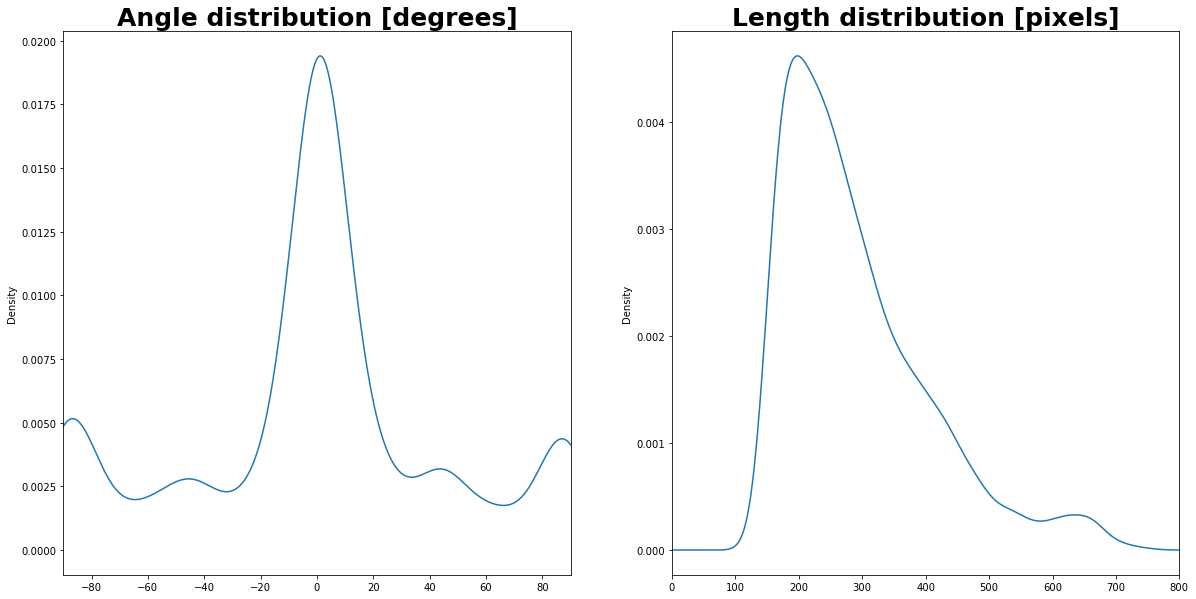

In [30]:
fig, ax = plt.subplots(ncols=2, nrows = 1, squeeze=False, figsize = (20,10))
data["angle"].plot(kind = "density", ax = ax[0,0])
ax[0,0].set_xlim((-90,90))
ax[0,0].set_title("Angle distribution [degrees]", size = 25, weight = "bold")

data["length"].plot(kind = "density", ax = ax[0,1])
ax[0,1].set_xlim((0,800))
ax[0,1].set_title("Length distribution [pixels]", size = 25, weight = "bold")

In [154]:
data= data.drop_duplicates(subset = ["length", "angle"])

Text(0.5, 1.0, 'Length distribution [pixels]')

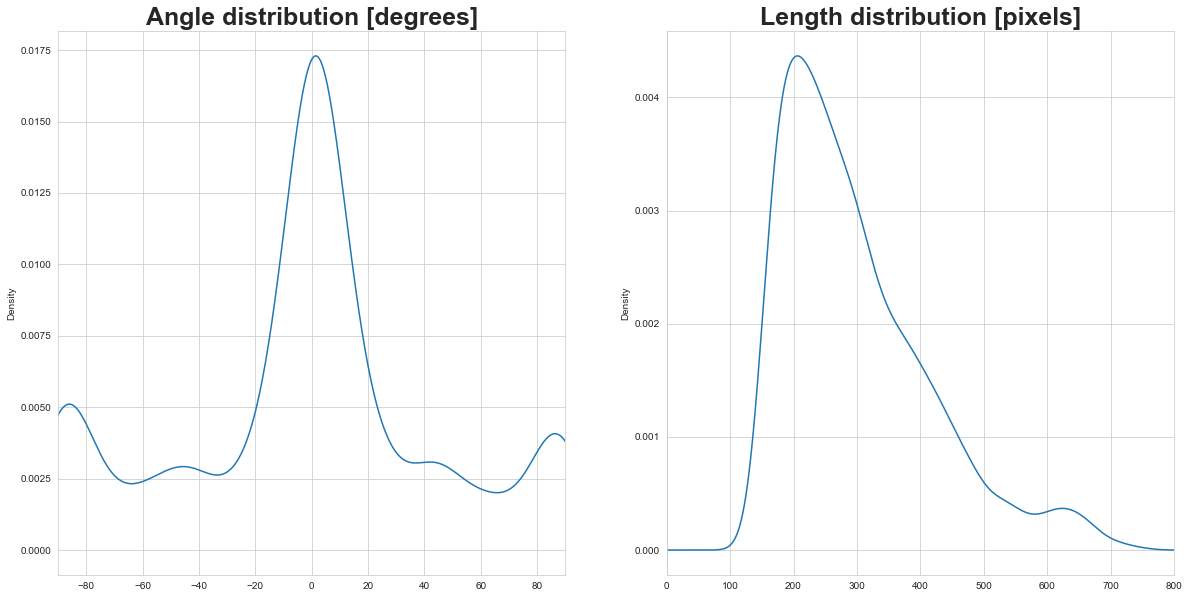

In [155]:
fig, ax = plt.subplots(ncols=2, nrows = 1, squeeze=False, figsize = (20,10))
data["angle"].plot(kind = "density", ax = ax[0,0])
ax[0,0].set_xlim((-90,90))
ax[0,0].set_title("Angle distribution [degrees]", size = 25, weight = "bold")

data["length"].plot(kind = "density", ax = ax[0,1])
ax[0,1].set_xlim((0,800))
ax[0,1].set_title("Length distribution [pixels]", size = 25, weight = "bold")

<ipython-input-10-6b4d87fe0ef6>:31: RuntimeWarning: divide by zero encountered in true_divide
  self.slope = y_diff/x_diff


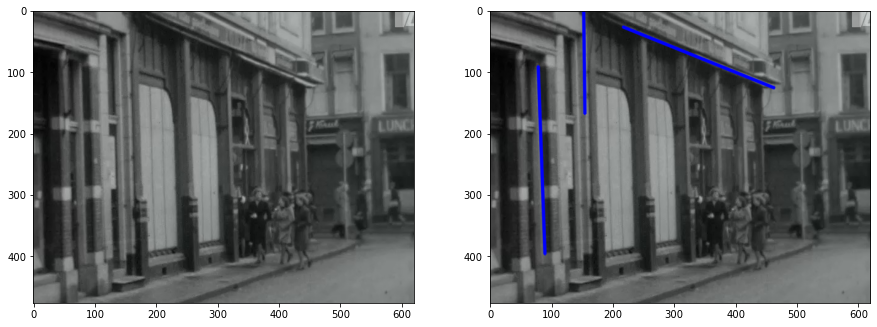

In [16]:
obj1 = matchingObjects("frames/AV0539/keyframe_2401.0.jpg")
obj2 = matchingObjects("frames/AV0539/keyframe_5741.0.jpg")

obj1.hough_lines(), obj2.hough_lines()
obj1.rank_and_pick_lines(delta_angle=3, max_lines=7), obj2.rank_and_pick_lines(delta_angle=3, max_lines=7), 
plot_lines(obj1.img, obj1.lines)

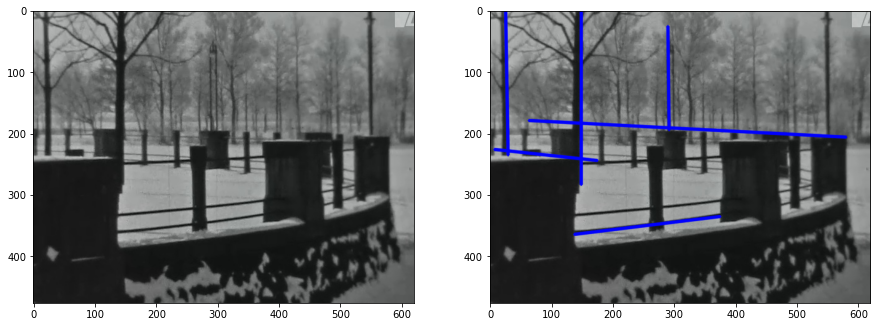

In [17]:
plot_lines(obj2.img, obj2.lines)

## Matching extracted lines to an image

<ipython-input-25-6b4d87fe0ef6>:31: RuntimeWarning: divide by zero encountered in true_divide
  self.slope = y_diff/x_diff


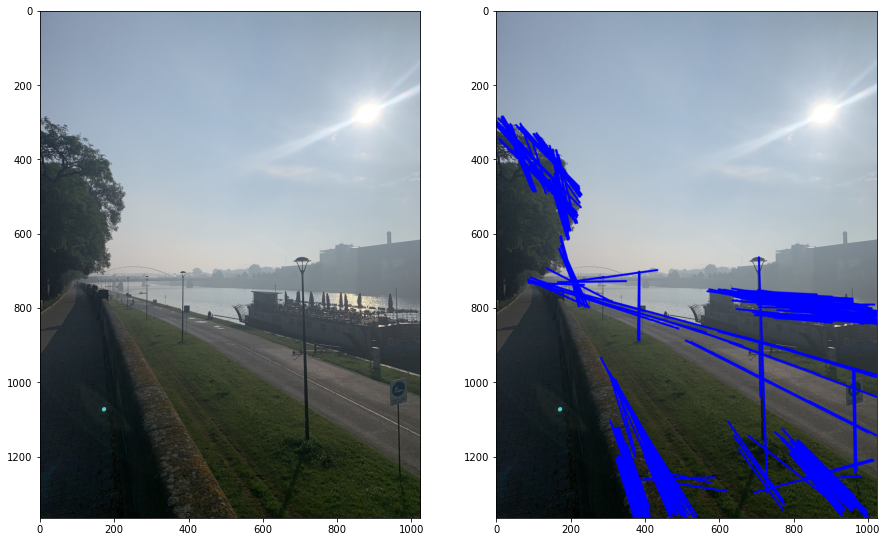

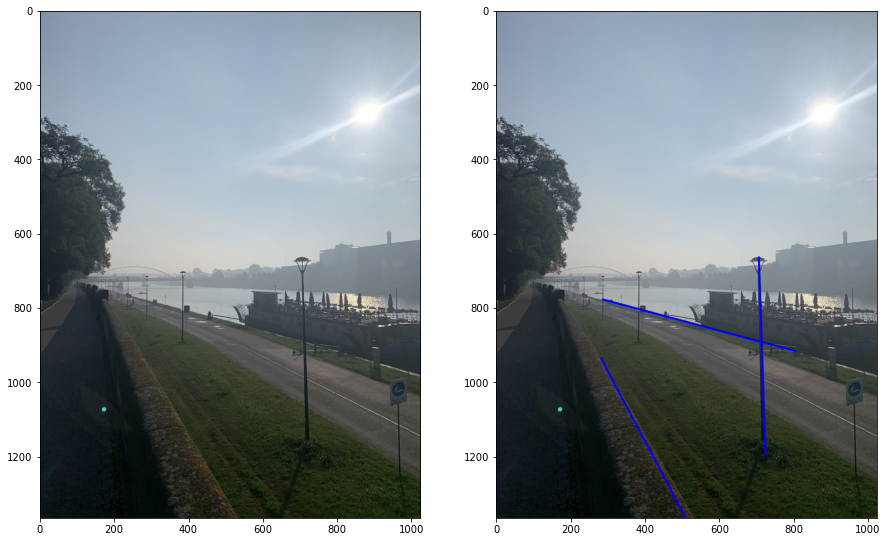

In [31]:
# Loading example image 

img = plt.imread("frames/contemporary/IMG_2864.jpeg")
#img = plt.imread("frames/contemporary/ams.jpg")
obj = matchingObjects(img = img, margin = 0)

obj.hough_lines()

plot_lines(obj.img, obj.lines, probabilistic= True)
obj.rank_and_pick_lines(delta_angle = 3, max_lines =3) # choose 5 best, diverse lines
plot_lines(obj.img, obj.lines, probabilistic=True)

## Query the data frame for similiar lines

bias the mathcing towards vertical lines

In [32]:
def match_lines(data, obj,delta_angle = 3):
    """
    
    Matches the lines of the given MatchingObject against the lines detected and stored in data
    
    Parameters:
    ------------------------
    data: pandas DataFrame
        database of lines with columns: path, angle, line, length
    obj: object of class MatchingObject
        an object of class matchingObjects for which the lines from data are matchted
    delta_angle: int
        what is the furthest angle to yield a match? Note that the matches are first filtered on angle and only then on length
    TO-DO: length_prop - the proportion of length to be qualified as a match, e.g. length_prop=0.5 means that the matched length must be at least
    
    Returns: pandas DataFrame
        database of lines with columns: path, angle, line, length
        
    """
    matches = pd.DataFrame()
    
    for i in range(len(obj.lines)):
        close_angle_data = data.loc[(data["angle"] < obj.angle[i][0] + delta_angle)  & (data["angle"] > obj.angle[i][0] - delta_angle)] # we first sort by angle as it is more important than length
        match = close_angle_data.iloc[(close_angle_data['length']-obj.length[i][0]).abs().argsort()][:1] # given the angle data, find the closest match in length
        match["obj_line"] = [obj.lines[i]]
        matches = pd.concat([matches, match])

    matches["line"] = matches["line"].apply(lambda x: x.flatten())
    matches["obj_line"] = matches["obj_line"].apply(lambda x: x.flatten())
    
    return matches

In [33]:
matches = match_lines(data,obj)

In [34]:
matches

path  angle                 line  length  \
1485   frames/AV0843/keyframe_9783.0.jpg  61.91  [170, 20, 399, 449]  486.29   
1276   frames/AV0843/keyframe_3520.0.jpg  85.95   [105, 7, 138, 473]  467.17   
2031  frames/AV5361/keyframe_17919.0.jpg  14.06   [57, 71, 584, 203]  543.28   

                   obj_line  
1485  [281, 934, 510, 1364]  
1276  [706, 663, 724, 1193]  
2031   [286, 777, 805, 916]

In [39]:
num = 1276
data.loc[num]

path      frames/AV0843/keyframe_3520.0.jpg
angle                                 85.95
line                   [[105, 7, 138, 473]]
length                               467.17
Name: 1276, dtype: object

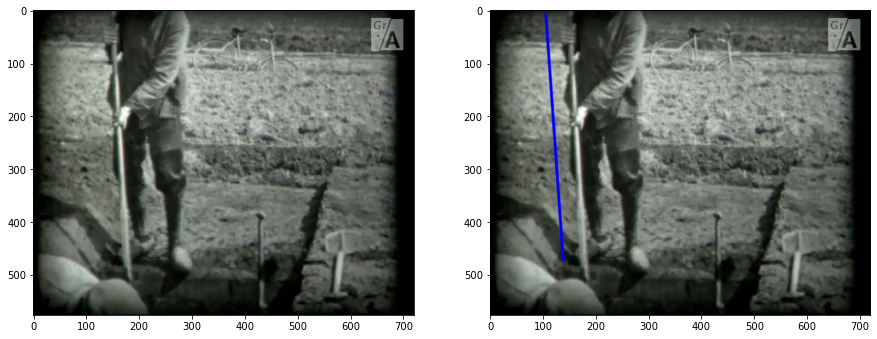

In [40]:
plot_lines(plt.imread(data.loc[num]['path']), [[data.loc[num]["line"][0]]])

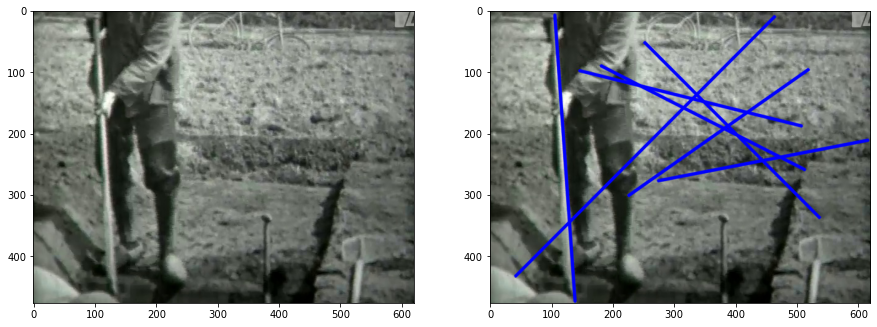

In [41]:
obj1 = matchingObjects(data.loc[num]["path"])
obj1.hough_lines()
obj1.rank_and_pick_lines(delta_angle = 3, max_lines = 7)
plot_lines(obj1.img, obj1.lines)


### Thoughts

- how to make matches good? Extra similiarity measure? What?
- how to bias towards vertical lines? Idea: scale the measurements to 0 mean and unit varaince and then compute a composite score length + X*angle (1 will correspond to 90 degrees)


In [42]:
np.expand_dims(data.loc[66]["line"], axis = 0).shape

(1, 1, 4)

In [19]:
plt.imshow(img_with_matches[org_line[1]:org_line[1] + org_line[3], org_line[0]: org_line[0] + org_line[2] ])

NameError: name 'img_with_matches' is not defined

In [20]:
img_with_matches = np.copy(obj.img)
buffer = 2
for num_matches in range(matches.shape[0]):
    
    match = matches.iloc[[num_matches]]
    take_from = plt.imread(match.index[0]) # load the image from which we take the line
    width, height, _ = take_from.shape
    
    org_line = match['obj_line'][0]
    new_line = match["line"][0]
    to_paste = cv2.resize(take_from[max(new_line[1] - buffer, 0): min(new_line[3] + buffer, height), max(new_line[0] - buffer, 0): min(new_line[2] + buffer, width)],
                         ( org_line[2]-org_line[0], org_line[3] - org_line[1]))
    
    #print(org_line)
    #print(to_paste.shape)
    #print(img_with_matches[org_line[1]: org_line[3], org_line[0]: org_line[2] ].shape)
    
    img_with_matches[org_line[1]: org_line[3], org_line[0]: org_line[2]] = to_paste
        

In [21]:
match

angle                 line      length  \
path                                                                            
frames/AV0539/keyframe_7253.0.jpg  14.005669  [166, 18, 607, 128]  454.511826   

                                               obj_line  
path                                                     
frames/AV0539/keyframe_7253.0.jpg  [286, 777, 805, 916]

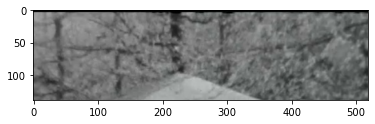

In [75]:
plt.imshow(to_paste)

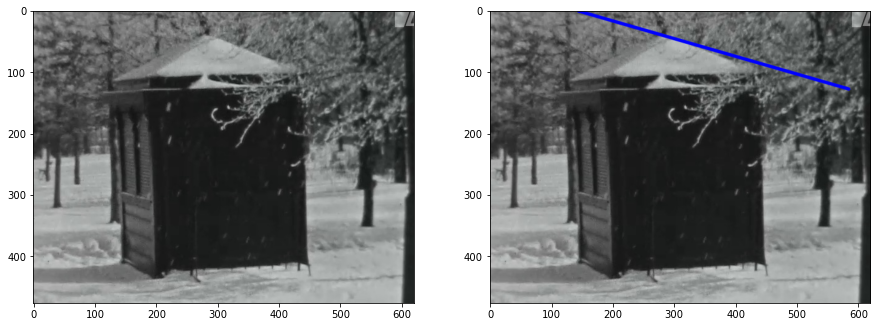

In [92]:
inv = matchingObjects(path = "frames/AV0539/keyframe_7264.0.jpg" )
inv.hough_lines()
inv.rank_and_pick_lines(max_lines = 3, delta_angle = 3)
plot_lines(inv.img, [inv.lines[-1]])

In [88]:
inv.lines

array([[[169, 131, 605, 116]],

       [[195,   3, 607, 169]],

       [[143,   1, 584, 128]]], dtype=int32)

In [90]:
obj.angle

array([[61.96210361],
       [88.05485324],
       [14.99323972]])

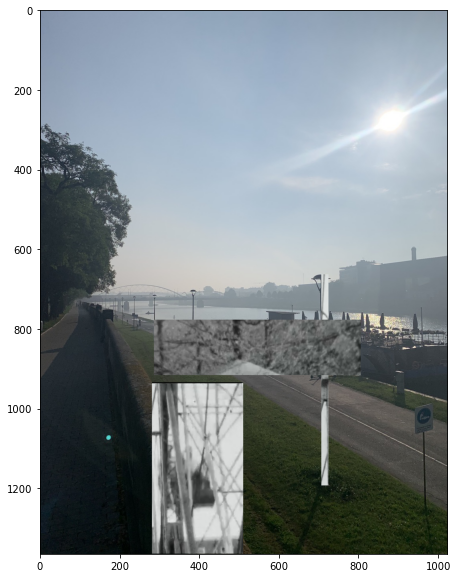

In [22]:
plt.figure(figsize = (10,10))
plt.imshow(img_with_matches)

In [60]:
img_with_matches[934:1364, 281:510].shape

(430, 229, 3)

In [61]:
org_line[1]

934

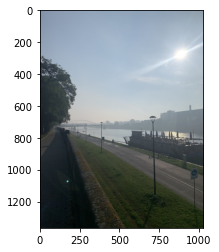

In [520]:
plt.imshow(img_with_matches)

In [ ]:
def plot_matches(matches, obj):
    

In [429]:
data.loc[data["angle"]> & data["len"]]

SyntaxError: invalid syntax (<ipython-input-429-0643b205cb28>, line 1)

In [444]:
delta_angle = 5 # what is the furthest angle to yield a match?
close_angle_data = data.loc[(data["angle"] < obj.angle[0][0] + delta_angle)  & (data["angle"] > obj.angle[0][0] - delta_angle)] # we first sort by angle as it is more important than length
match = close_angle_data.iloc[(close_angle_data['length']-obj.length[0][0]).abs().argsort()][:1] # given the angle data, find the closest match in length

In [485]:
k = pd.concat([pd.DataFrame(), match])
k["arka"] = 2

In [486]:
k

angle                  line  \
path                                                                 
frames/AV0539/keyframe_7120.0.jpg  64.958414  [[321, 9, 499, 390]]   

                                       length  arka  
path                                                 
frames/AV0539/keyframe_7120.0.jpg  420.529428     2

In [454]:
match.index[0]

'frames/AV0539/keyframe_7120.0.jpg'

In [52]:
match_img = plt.imread(match.index[0])
buffer = 3
match_img[9:390, 321:390].shape

(381, 69, 3)

In [441]:
obj.angle[0][0]

61.9621036054125

In [442]:
obj.length

array([[487.17655937],
       [530.30557229],
       [537.29135485]])

In [443]:
data.iloc[(data['angle']-obj.angle[0][0]).abs().argsort()][:1]

angle                 line      length
path                                                                          
frames/AV0539/keyframe_12514.0.jpg  61.949224  [[61, 0, 207, 274]]  310.470611

In [ ]:
# pick longest lines, diveristy parameter for the angle

In [109]:
get_angle(hough_lines)

array([[ 0.46760016],
       [ 1.53660443],
       [ 0.26320946],
       [ 0.78539816],
       [ 0.03569911],
       [ 0.45463884],
       [ 0.26250675],
       [ 1.04699728],
       [ 0.83752481],
       [ 0.47153699],
       [ 0.46876265],
       [ 1.32974306],
       [ 1.04542945],
       [ 0.19220829],
       [-0.01844809],
       [ 0.34956183],
       [ 1.32387403],
       [ 0.20934158],
       [ 1.14992417],
       [ 0.03729613],
       [ 0.85433109],
       [ 0.26082388],
       [ 1.15077182],
       [ 0.85480521],
       [ 1.13511345],
       [ 1.15043616],
       [ 0.18932192],
       [ 1.32679423],
       [ 1.3277959 ],
       [ 0.05180546],
       [ 0.12352889],
       [ 0.15541845],
       [ 0.15819996],
       [ 0.19043512],
       [ 0.47052035],
       [ 0.15482041],
       [ 0.05473978],
       [ 0.05233312],
       [ 0.08659958],
       [ 0.05180546],
       [ 0.19288431],
       [ 0.19260326],
       [ 0.1740036 ],
       [ 1.32974306],
       [ 1.14937712],
       [ 1

In [106]:
np.arctan2(hough_lines[:, :,3] - hough_lines[:, :,1], hough_lines[:, :,2] - hough_lines[:, :,0])# * 180/np.pi

array([[26.79151553],
       [88.04094839],
       [15.08079131],
       [45.        ],
       [ 2.04540849],
       [26.04888695],
       [15.04052877],
       [59.9885253 ],
       [47.98663699],
       [27.01707951],
       [26.85812166],
       [76.18866521],
       [59.89869543],
       [11.0127236 ],
       [-1.05699778],
       [20.02841753],
       [75.85239461],
       [11.9943892 ],
       [65.88580146],
       [ 2.13691085],
       [48.94956564],
       [14.94410727],
       [65.93436842],
       [48.97673098],
       [65.03721017],
       [65.91513663],
       [10.84734684],
       [76.01970942],
       [76.07710115],
       [ 2.96823403],
       [ 7.07768403],
       [ 8.90482099],
       [ 9.06418991],
       [10.91112838],
       [26.9588304 ],
       [ 8.87055586],
       [ 3.13635837],
       [ 2.99846714],
       [ 4.96179071],
       [ 2.96823403],
       [11.05145703],
       [11.03535416],
       [ 9.96967195],
       [76.18866521],
       [65.85445804],
       [65